Math 5750/6880: Mathematics of Data Science \
Project 2

# 1. Clustering Gaussian Blobs using $k$-means

In this exercise, you will perform a cluster analysis on a synthetically generated “Gaussian Blobs” dataset.
- Finally, perform an “elbow analysis” to justify the use of k = 5.

In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

# Generate 5 Gaussian blobs in 10 dimensions
X, y_true = make_blobs(
    n_samples=1000,
    centers=5,
    n_features=10,
    cluster_std=1.5,
    random_state=1)        # reproducibility
X = StandardScaler().fit_transform(X)

print(type(X),X.shape)
print(type(y_true),y_true.shape)

<class 'numpy.ndarray'> (1000, 10)
<class 'numpy.ndarray'> (1000,)


In [15]:
# Perform a k-means cluster analysis with k = 5. Report the smallest k-means inertia value.
kmeans = KMeans(n_clusters=5, n_init=50, random_state=1).fit(X)
print("Smallest k-means inertia value:", kmeans.inertia_)

Smallest k-means inertia value: 924.3159961688092


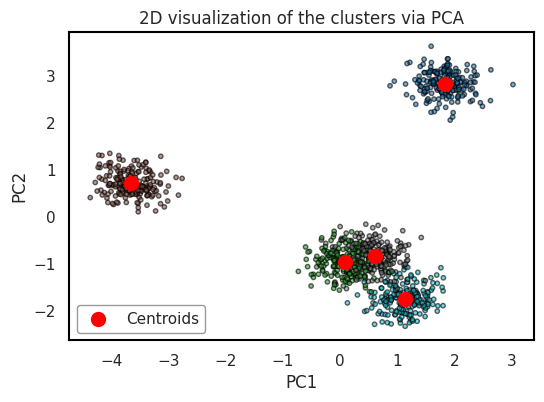

In [98]:
# Make a 2D visualization of the clusters via PCA
# Including both the clusters (colored by cluster) and the cluster centers.
# Reduce data to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
centers_pca = pca.transform(kmeans.cluster_centers_)

# Plot the clusters and cluster centers
plt.figure(figsize=(6,4), facecolor="white")
ax = plt.gca()
ax.set_facecolor("white")

for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

# Plot data points
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans.labels_,
            cmap="tab10", s=10, edgecolor="black", alpha=0.6)

# Plot red dot centroids
plt.scatter(
    centers_pca[:,0], centers_pca[:,1],
    c="red", s=90, marker="o", linewidth=1.5, label="Centroids"
)

plt.title("2D visualization of the clusters via PCA")
plt.legend(loc="lower left", facecolor="white", edgecolor="gray")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

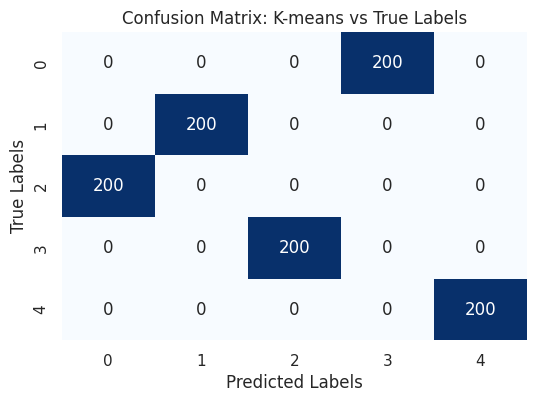

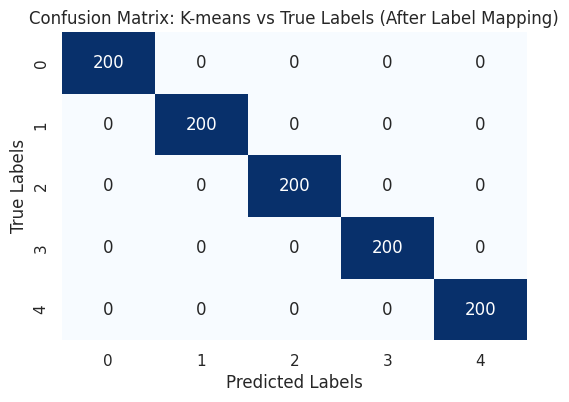

In [97]:
from scipy.optimize import linear_sum_assignment
# Make a confusion matrix that compares your assigned labels to the “true labels.
cm = confusion_matrix(y_true, kmeans.labels_)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix: K-means vs True Labels")
plt.show()

# Here, you’ll have to figure out how to best match the predicted and true labels.
# Use Hungarian algorithm to find best cluster-to-label mapping
row_ind, col_ind = linear_sum_assignment(-cm)
mapping = dict(zip(col_ind, row_ind))

# Remap K-means labels according to mapping
new_labels = np.array([mapping[label] for label in kmeans.labels_])

# Final confusion matrix after remapping
final_conf_mat = confusion_matrix(y_true, new_labels)
plt.figure(figsize=(6,4))
sns.heatmap(final_conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix: K-means vs True Labels (After Label Mapping)")
plt.show()



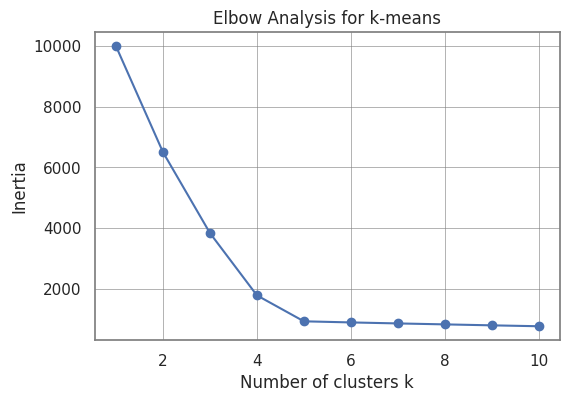

In [110]:
inertias = []
ks = range(1, 11)
for k in ks:
    km = KMeans(n_clusters=k, n_init=50, random_state=1)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(ks, inertias, '-o')
plt.gca().set_facecolor("white")  # white background
plt.grid(True, color="gray", linewidth=0.7, alpha=0.6)
for spine in plt.gca().spines.values():
    spine.set_edgecolor("gray")
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia")
plt.title("Elbow Analysis for k-means")
plt.show()

# 2. Clustering Fashion-MNIST using $k$-means

In this exercise, you will import and perform
a cluster analysis on the Fashion-MNIST dataset. \\
1. Use the provided code to import the dataset as a
numpy array. \\
2. To get a sense of this dataset, first make a 5×2 array of figures, each plotting a distinct
article of clothing. \\
3. Write code to perform a k-means cluster analysis on this dataset, centering/scaling as appropriate. This is a larger dataset, so you may have to reduce the dimension/sample size as appropriate.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Load Fashion-MNIST from OpenML
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

print(type(X),X.shape)
print(type(y),y.shape)

<class 'numpy.ndarray'> (70000, 784)
<class 'numpy.ndarray'> (70000,)


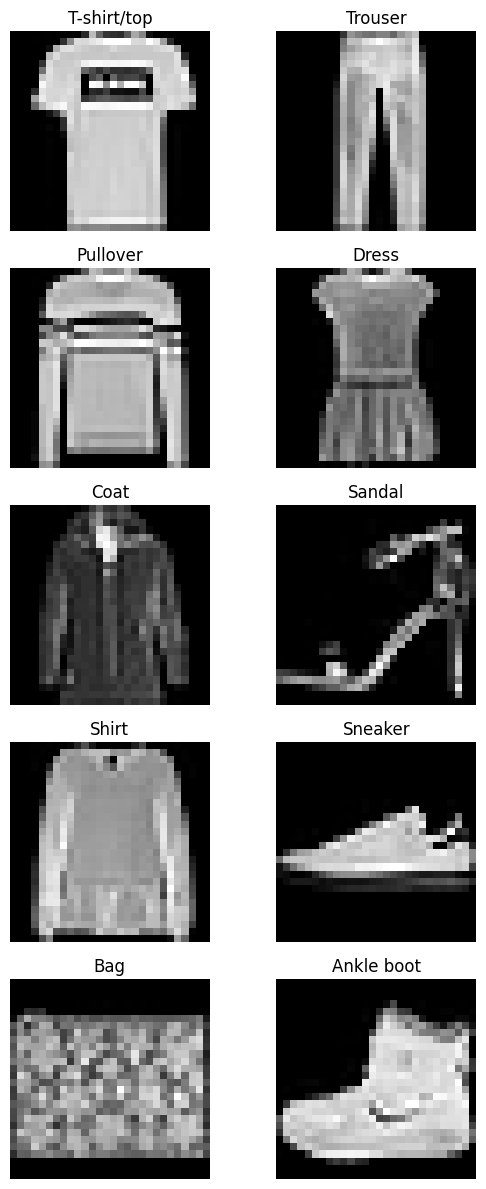

In [6]:
# a 5×2 array of figures, each plotting a distinct article of clothing.
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
fig, axes = plt.subplots(5, 2, figsize=(6, 12))
axes = axes.flatten()

for i in range(10):
    # Find the first index of each class
    idx = np.where(y == i)[0][0]
    image = X[idx].reshape(28, 28)

    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(class_names[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Cluster labels shape: (10000,)


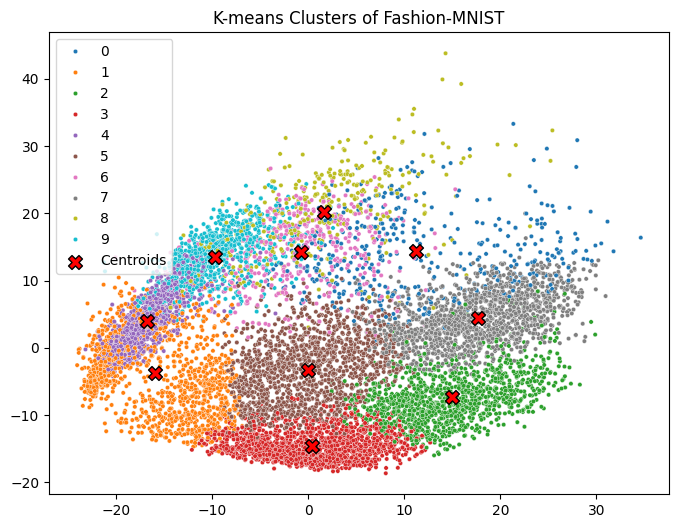

In [29]:
# Take a random sample to reduce computation
sample_size = 10000
idx = np.random.choice(range(X.shape[0]), size=sample_size, replace=False)
X_sample = X[idx]

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

# Reduce to 50D using PCA (before clustering)
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Run K-means with 10 clusters
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

print("Cluster labels shape:", clusters.shape)

# ----------------------------
# 4. Visualize clusters (2D PCA projection)
# ----------------------------
pca2 = PCA(n_components=2, random_state=42)
X_2d = pca2.fit_transform(X_pca)

centroids_2d = pca2.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_2d[:,0], y=X_2d[:,1],
    hue=clusters, palette="tab10", s=10, legend="full"
)

# Plot centroids as red dots
plt.scatter(
    centroids_2d[:,0], centroids_2d[:,1],
    c="red", s=100, marker="X", edgecolor="black", label="Centroids"
)

plt.title("K-means Clusters of Fashion-MNIST")
plt.legend()
plt.show()

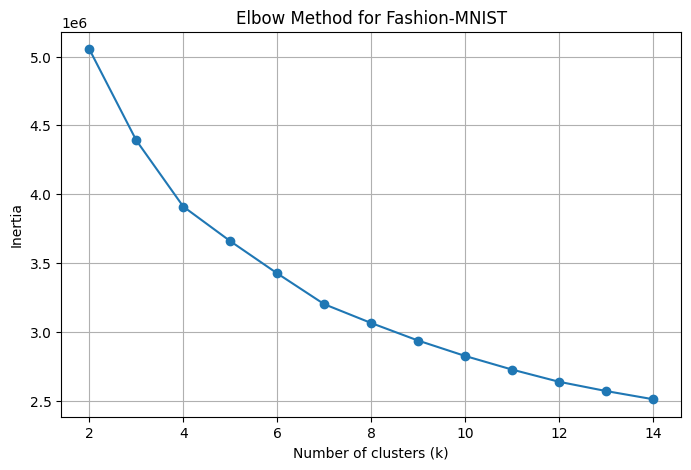

In [32]:
inertias = []
K_range = range(2, 15)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_pca)   # use PCA-reduced data (e.g., 50D)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Fashion-MNIST")
plt.grid(True)
plt.show()

# 3. Dimensionality reduction for Fashion-MNIST

In this exercise, you will compare PCA
and Random Projection on the Fashion-MNIST dataset. The goal of this exercise is to better understand how Random Projections performs as we vary dimension (Johnson–Lindenstrauss Lemma). \\
1. Import the data and center/scale as appropriate. \\
2. Implement both PCA and Random Projection
methods for target dimensions $k \in \{10, 20, 50, 100, 200\}.$ \\
3. For each reduced dataset, compute the
correlation between pairwise distances in the original standardized space and the reduced space. \\
4. Make a plot of this correlation vs. k for the two methods.

In [ ]:
# your code here

# 4. Clustering Fashion-MNIST using spectral clustering

In this exercise, you will again
perform a cluster analysis on the Fashion-MNIST dataset. \\
1. Write code to use spectral clustering to
cluster the data. \\
2. Again, this is a larger dataset, so you may have to reduce the dimension/sample size as appropriate.

In [ ]:
# your code here